In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# skip --> do not have to run
!pip install -q condacolab
import condacolab
condacolab.install()
!conda update conda
!conda init bash
!source ~/.bashrc

%cd drive/MyDrive/dslab/ds-lab-2022-p2-cyclone/
!conda env create -f env_colab.yml

!pip install matplotlib
!pip install torch
!pip install netCDF4
!pip install pandas
!pip install scikit-learn

!conda init bash
!source ~/.bashrc
!conda activate dslab

In [ ]:
# ensure to have this SHAP version installed!
!pip install https://github.com/ceshine/shap/archive/master.zip

In [2]:
%cd /content/drive/MyDrive/dslab/ds-lab-2022-p2-cyclone/

/content/drive/MyDrive/dslab/ds-lab-2022-p2-cyclone


In [ ]:
import torch
from torch import nn, transpose
from torch.utils.data import DataLoader
import os
import pandas as pd
import numpy as np; np.random.seed(0)
import matplotlib.pyplot as plt
import shap
import seaborn as sns; sns.set_theme()

from model import TCN_GRU
from loaddata import CycloneDataset, CycloneDatasetSHAP
from utils import moving_average, MSELoss_denorm
from train import train, evaluate_denorm, evaluate

### Tuning params

In [ ]:
!python test_data_generation.py

***********Data extraction complete*************
Processing:  predictors
extracting data from 2009 in month 01
extracting data from 2009 in month 02
extracting data from 2009 in month 03
extracting data from 2009 in month 04
extracting data from 2009 in month 05
extracting data from 2009 in month 06
extracting data from 2009 in month 07
extracting data from 2009 in month 08
extracting data from 2009 in month 09
extracting data from 2009 in month 10
extracting data from 2009 in month 11
extracting data from 2009 in month 12
===========extract_timeseries.Raw data complete!============
=======Rawdata. test data standardization complete=======
===========extract_timeseries.clp_std complete!============
extracting 0 cyclones with 0 subtracks
extracting 10000 cyclones with 136184 subtracks
===========extract_timeseries: 13853 cyclone tracks with 187617 sub-tracks extraction complete!============
tcmalloc: large alloc 3813883904 bytes == 0x55e22479a000 @  0x7f57a71441e7 0x7f57a552e0ce 0x7f57a

In [ ]:
train_path = 'datasets/train_N_extra'
test_path = 'datasets/test_N_extra'
if not os.path.exists(train_path):
    os.makedirs(train_path)
if not os.path.exists(test_path):
    os.makedirs(test_path)

BATCH_SIZE = 64

train_labels = pd.read_pickle(train_path + "/train_labels.pkl")
val_labels = pd.read_pickle(train_path + "/val_labels.pkl")
train_meta = pd.read_pickle(train_path + "/train_meta.pkl")
val_meta = pd.read_pickle(train_path + "/val_meta.pkl")
train_ra = pd.read_pickle(train_path + "/train_ra.pkl")
val_ra = pd.read_pickle(train_path + "/val_ra.pkl")
scaler_dict = pd.read_pickle(train_path + "/scaler_dict.pkl")

test_labels = pd.read_pickle(test_path + "/labels.pkl")  
test_meta = pd.read_pickle(test_path + "/meta_features.pkl")    
test_ra = pd.read_pickle(test_path + "/ra_features.pkl")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using {} to process".format(device))

# flatten the ra features for shap explainer
train_dataset = CycloneDatasetSHAP(train_meta, train_ra, train_labels, device)
val_dataset = CycloneDatasetSHAP(val_meta, val_ra, val_labels, device)
test_dataset = CycloneDatasetSHAP(test_meta, test_ra, test_labels, device)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

Using cuda to process


#### 1 GRU_TCN

In [ ]:
# Settings
n_epochs = 1
input_channels = 79  # calculate based on the CNN setting
output_size = 6
# Note: We use a very simple setting here (assuming all levels have the same # of channels.
channel_sizes = [64] * 3 # [num of hidden units per layer] * num of levels
kernel_size = 3
dropout = 0.2
hidden_size = 128
num_layers = 8
learning_rate = 1e-4 / 5

In [ ]:
model = TCN_GRU(input_channels, output_size, channel_sizes, kernel_size, dropout, hidden_size, num_layers, device).to(device)
model.init_hidden(BATCH_SIZE)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)
loss_fn = nn.MSELoss()


train(n_epochs, model, train_loader, val_loader, optimizer, loss_fn, 'GRU_TCN', lr_scheduler, init_h = True)

denorm_model_loss, denorm_model_loss_ts = evaluate_denorm(model, test_loader, loss_fn, scaler_dict, init_h = True)
model_loss, model_loss_ts = evaluate(model, test_loader, loss_fn, init_h = True)
print("====================Compare on test set:===============================")
print(f"Over all timestep: \n GRU_TCN normed MSE: {model_loss} \n GRU_TCN denormed MSE {denorm_model_loss}")
print(f"By each timestep: \n GRU_TCN normed MSE: {model_loss_ts} \n GRU_TCN denormed MSE: {denorm_model_loss_ts}")

TCN_GRU(
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(79, 64, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.2, inplace=False)
        (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.2, inplace=False)
        (net): Sequential(
          (0): Conv1d(79, 64, kernel_size=(3,), stride=(1,), padding=(2,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout(p=0.2, inplace=False)
          (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,))
          (5): Chomp1d()
          (6): ReLU()
          (7): Dropout(p=0.2, inplace=False)
        )
        (downsample): Conv1d(79, 64, kernel_size=(1,), stride=(1,))
        (relu): ReLU()
      )
      (1): TemporalBlock(
        (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(

In [84]:
#calculate the baseline MSE (normalized)
train_path = 'datasets/train_N_extra'
scaler_dict = pd.read_pickle(train_path + "/scaler_dict.pkl")
test_dataset = CycloneDataset(test_meta, test_ra, test_labels, device)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)
test_moving_avg = moving_average(test_meta)
norm_MSE = MSELoss_denorm(output = test_moving_avg, label = test_labels, scaler_dict = scaler_dict, denorm = False, time_sep = True)

denormed_MSE = MSELoss_denorm(output = test_moving_avg, label = test_labels, scaler_dict = scaler_dict, denorm = True, time_sep = True)

print("Over all timestep: \nBaseline normed MSE: {} \nBaseline denormed MSE: {}"
    .format(MSELoss_denorm(output = test_moving_avg, label = test_labels, scaler_dict = scaler_dict, denorm = False, time_sep = False), 
            MSELoss_denorm(output = test_moving_avg, label = test_labels, scaler_dict = scaler_dict, denorm = True, time_sep = False)))

print("By each timestep: \nBaseline normed MSE: {} \nBaseline denormed MSE: {}".format(norm_MSE, denormed_MSE))

Over all timestep: 
Baseline normed MSE: 0.03451687177109184 
Baseline denormed MSE: 5.499470848271481
By each timestep: 
Baseline normed MSE: [0.01613934554214624, 0.021479448146718212, 0.02810591398259479, 0.036231672443028766, 0.04624401181895054, 0.05890083869310984] 
Baseline denormed MSE: [2.5714340774516344, 3.4222567938143036, 4.478031950182638, 5.77268495551895, 7.367921305036524, 9.384496007624543]


### Plot learning curve

In [ ]:
# plot learning curve
def plot_learning(loss_dict):
  n_epochs = len(loss_dict['val'])
  x_epoch = [int(i+1) for i in range(n_epochs)]
  train = loss_dict['train']
  val = loss_dict['val']
  train = [i.to(torch.device("cpu")).detach().numpy() for i in train]
  plt.plot(x_epoch, train, label = 'train')
  plt.plot(x_epoch, val, label = 'val')
  plt.legend(loc = 'best')
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.show()

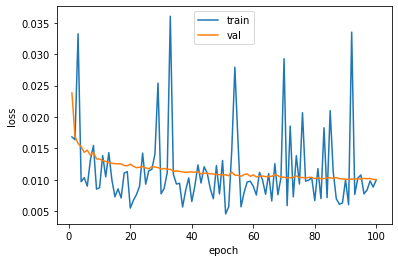

In [ ]:
loss_dict = pd.read_pickle("datasets/loss_dicts/GRU_TCN_100.pkl")
plot_learning(loss_dict)

### SHAP Feature importance

In [6]:
# load test data
test_path = 'datasets/test_N_extra'
test_labels = pd.read_pickle(test_path + "/labels.pkl")  
test_meta = pd.read_pickle(test_path + "/meta_features.pkl")    
test_ra = pd.read_pickle(test_path + "/ra_features.pkl")

BATCH_SIZE = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using {} to process".format(device))

# flatten the ra features for shap explainer
test_dataset = CycloneDatasetSHAP(test_meta, test_ra, test_labels, device)

test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

Using cuda to process


In [54]:
# load the model to explain
save_path = 'datasets/checkpoints/GRU_TCN_100.tar'
checkpoint = torch.load(save_path, map_location="cpu")
args = checkpoint['args']
learning_rate = 1e-4 / 5

model = TCN_GRU(args['input_size'], args['output_size'], args['num_channels'], args['kernel_size'], args['dropout'], args['hidden_size'], args['n_layers'], "cpu").to("cpu")
#model = TCN_GRU(**checkpoint['args']).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
NUM_EPOCH = checkpoint['epoch']

In [9]:
bg_data = next(iter(test_loader))[0].to("cpu")
explain_data = next(iter(test_loader))[0].to("cpu")

In [55]:
%%time
model.init_hidden(BATCH_SIZE)
e = shap.DeepExplainer(
        model, 
        bg_data,
        )

CPU times: user 102 ms, sys: 0 ns, total: 102 ms
Wall time: 25.5 ms


In [56]:
%%time
model.init_hidden(128)
shap_values = e.shap_values(
    explain_data
)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1023: UserWarning: Using a non-full backward hook when outputs are generated by different autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when outputs are generated by different autograd Nodes "


CPU times: user 2min 35s, sys: 16.3 s, total: 2min 51s
Wall time: 52 s


In [18]:
shap_values[1].shape

(64, 6, 862)

In [57]:
shap_val = np.array(shap_values)
shap_abs = np.absolute(shap_val)
sum_0 = np.sum(shap_abs[0],axis=0) # contribution to the prediction of t+1

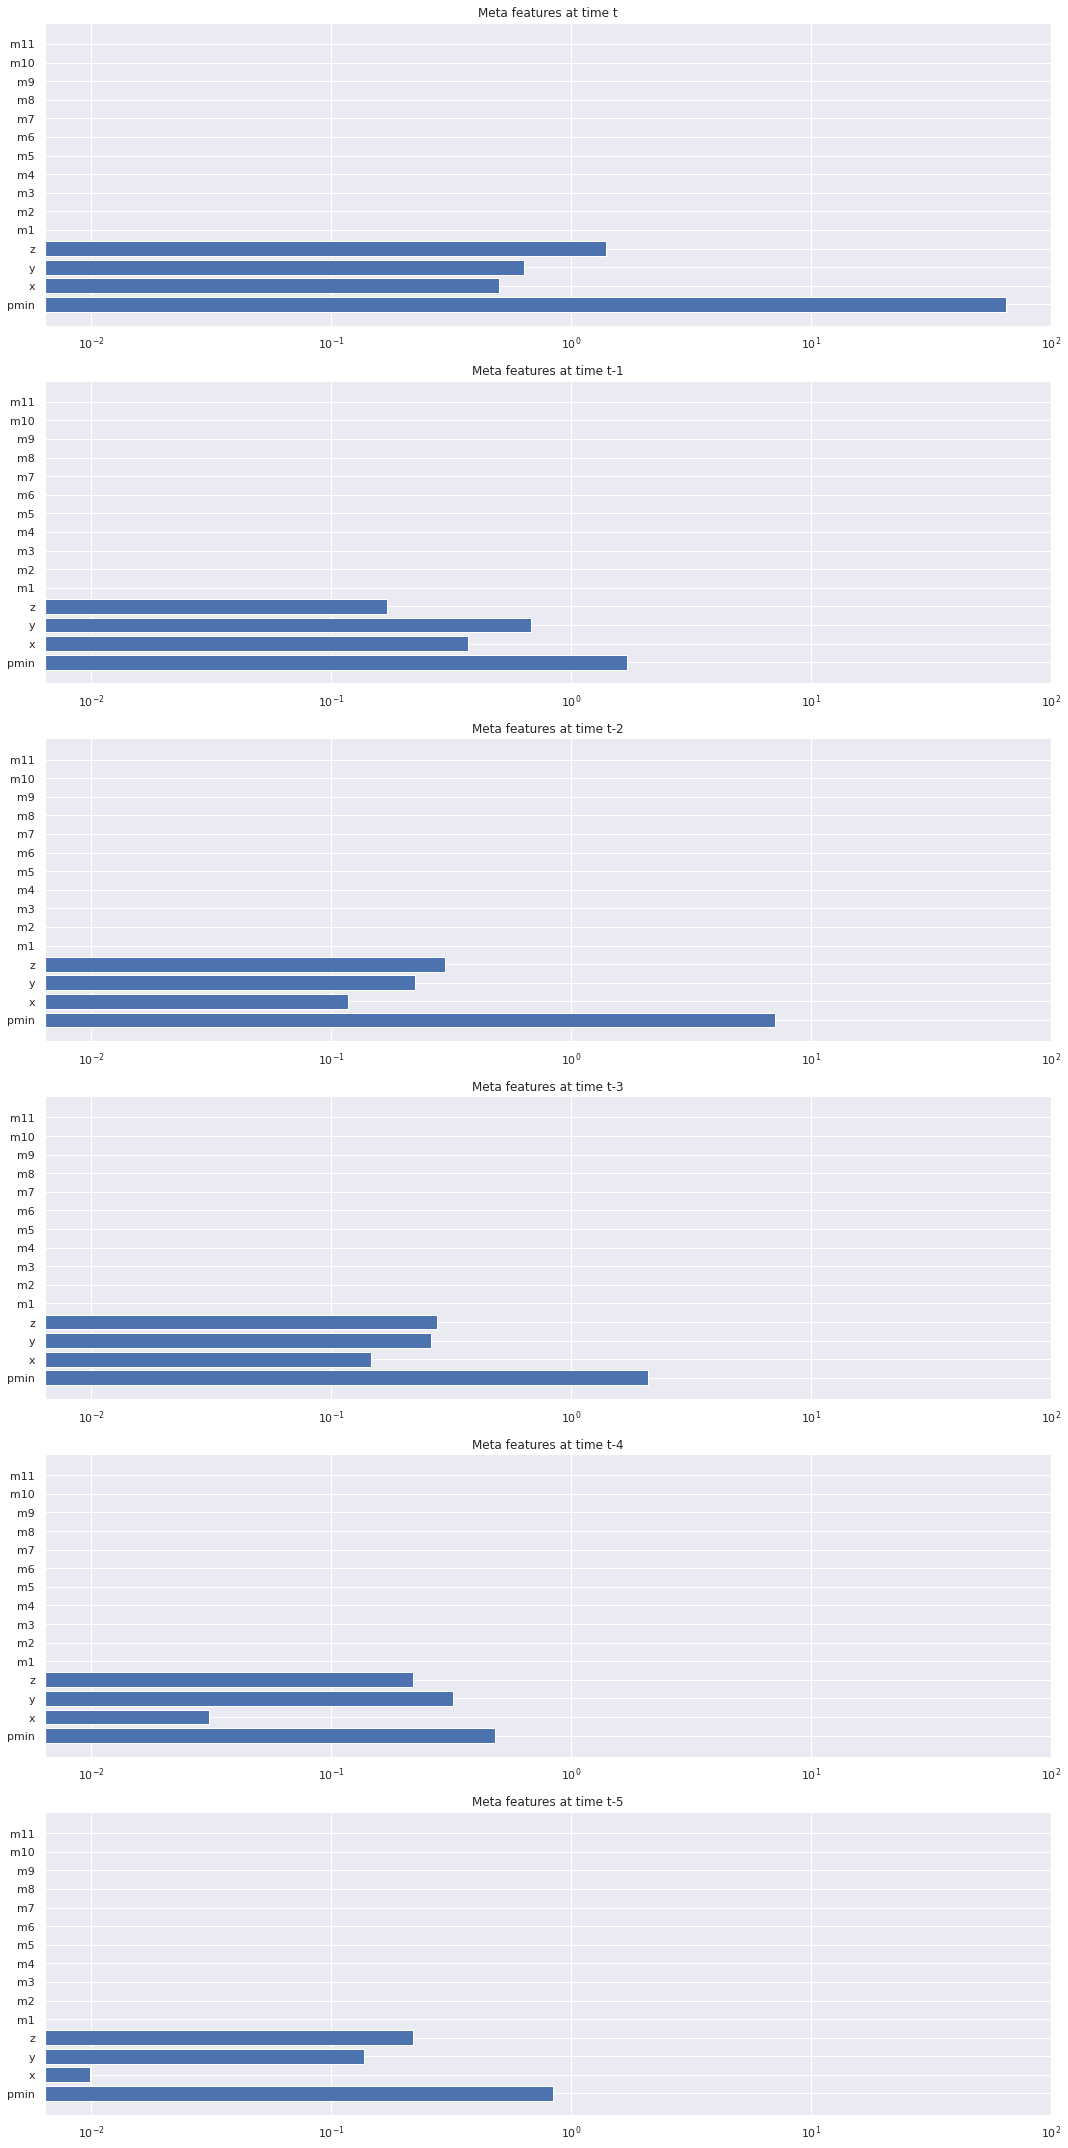

In [58]:
sum_0_meta = sum_0[:, :15]
f_names = ['pmin', 'x', 'y', 'z', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11']
x_pos = [i for i, _ in enumerate(f_names)]

fig = plt.figure(figsize=(15, 30))
plt1 = fig.add_subplot(611)
plt1.barh(x_pos,sum_0_meta[5])
plt1.set_yticks(x_pos)
plt1.set_yticklabels(f_names)
plt1.set_title("Meta features at time t")

plt2 = fig.add_subplot(612,sharex=plt1)
plt2.barh(x_pos,sum_0_meta[4])
plt2.set_yticks(x_pos)
plt2.set_yticklabels(f_names)
plt2.set_title("Meta features at time t-1")

plt2 = fig.add_subplot(613,sharex=plt1)
plt2.barh(x_pos,sum_0_meta[3])
plt2.set_yticks(x_pos)
plt2.set_yticklabels(f_names)
plt2.set_title("Meta features at time t-2")

plt2 = fig.add_subplot(614,sharex=plt1)
plt2.barh(x_pos,sum_0_meta[2])
plt2.set_yticks(x_pos)
plt2.set_yticklabels(f_names)
plt2.set_title("Meta features at time t-3")

plt2 = fig.add_subplot(615,sharex=plt1)
plt2.barh(x_pos,sum_0_meta[1])
plt2.set_yticks(x_pos)
plt2.set_yticklabels(f_names)
plt2.set_title("Meta features at time t-4")

plt2 = fig.add_subplot(616,sharex=plt1)
plt2.barh(x_pos,sum_0_meta[0])
plt2.set_yticks(x_pos)
plt2.set_yticklabels(f_names)
plt2.set_title("Meta features at time t-5")
plt2.set_xscale('log')

plt.tight_layout()
plt.show()

In [59]:
# plot the ra feature importance of each timestep
sum_0_ra = sum_0[:, 15:].reshape(-1, 7, 11, 11) 

In [44]:
sum_0_ra.shape

(6, 7, 11, 11)

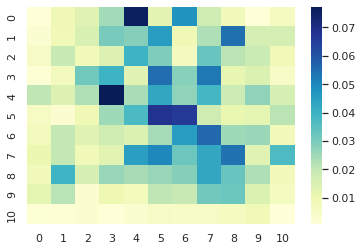

In [65]:
ax = sns.heatmap(sum_0_ra[5][0], cmap="YlGnBu")

In [75]:
def SHAP_ra(feature_id, timestep, shap_abs):
  """Plot the importance of ra_cols[feature_id] over time to the prediction of timestep (0 - 6)
  """
  ra_cols = ['U300', 'V300', 'U500', 'V500', 'T850', 'MSL', 'PV320']
  sum_t = np.sum(shap_abs[timestep],axis=0) # contribution to the prediction of timestep  
  sum_ra = sum_t[:, 15:].reshape(-1, 7, 11, 11) 
  fig, axn = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(20, 10))
  cbar_ax = fig.add_axes([.91, .3, .03, .4])
  fig.suptitle(f'SHAP contribution of {ra_cols[feature_id]} to predict pmin at time t+{str(timestep+1)}', fontsize=16)

  for i, ax in enumerate(axn.flat):
      sns.heatmap(sum_0_ra[i][feature_id], ax=ax,
                  cbar=i == 0,
                  vmin=0, vmax=0.1,
                  cbar_ax=None if i else cbar_ax)
      ax.set_xlabel(f'Time t-{str(5 - i)}' if i < 5 else f'Time t')

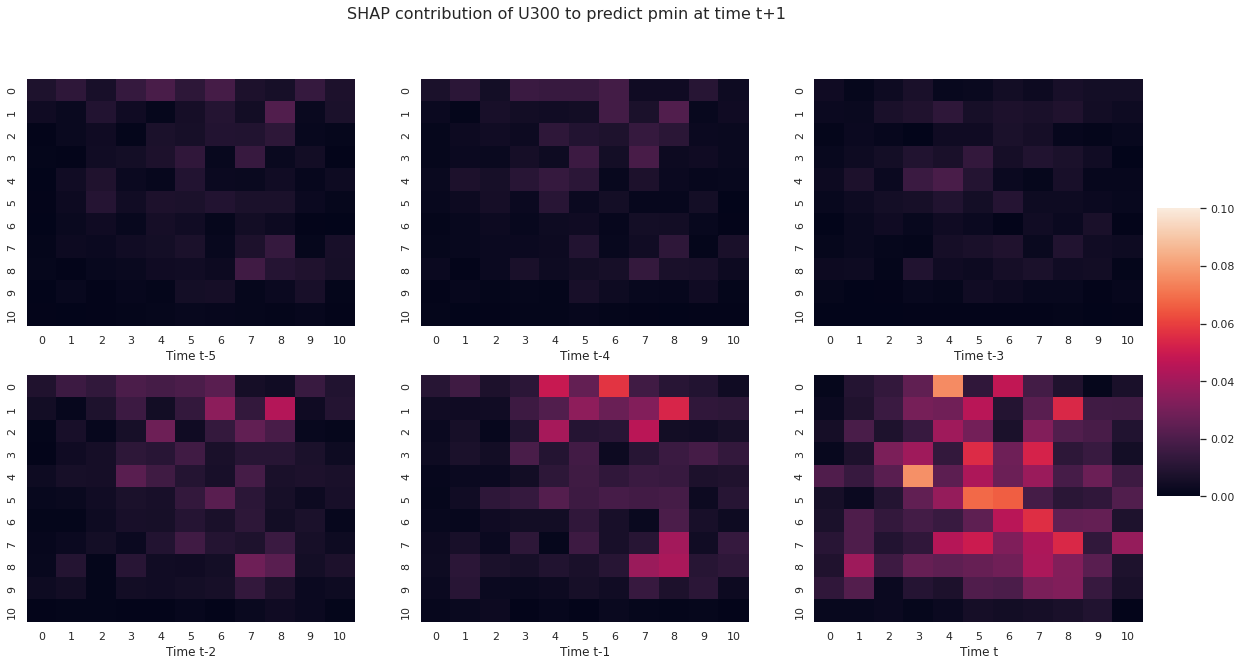

In [76]:
SHAP_ra(feature_id = 0, timestep = 0, shap_abs = shap_abs)

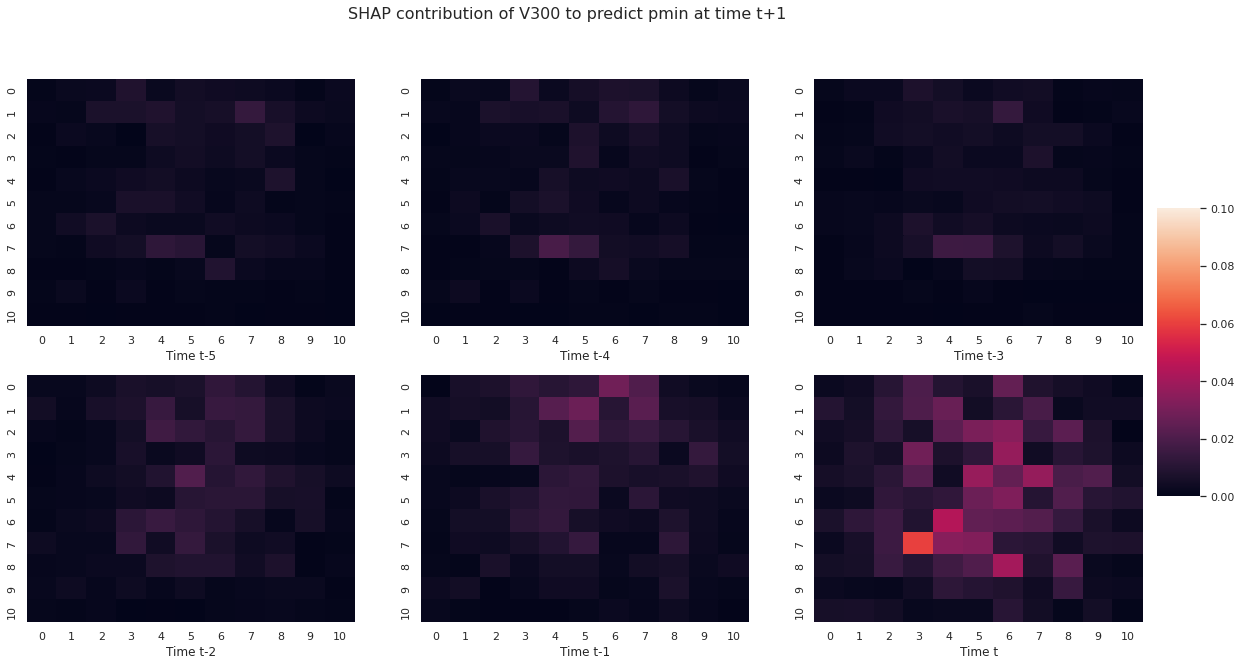

In [77]:
SHAP_ra(feature_id = 1, timestep = 0, shap_abs = shap_abs)

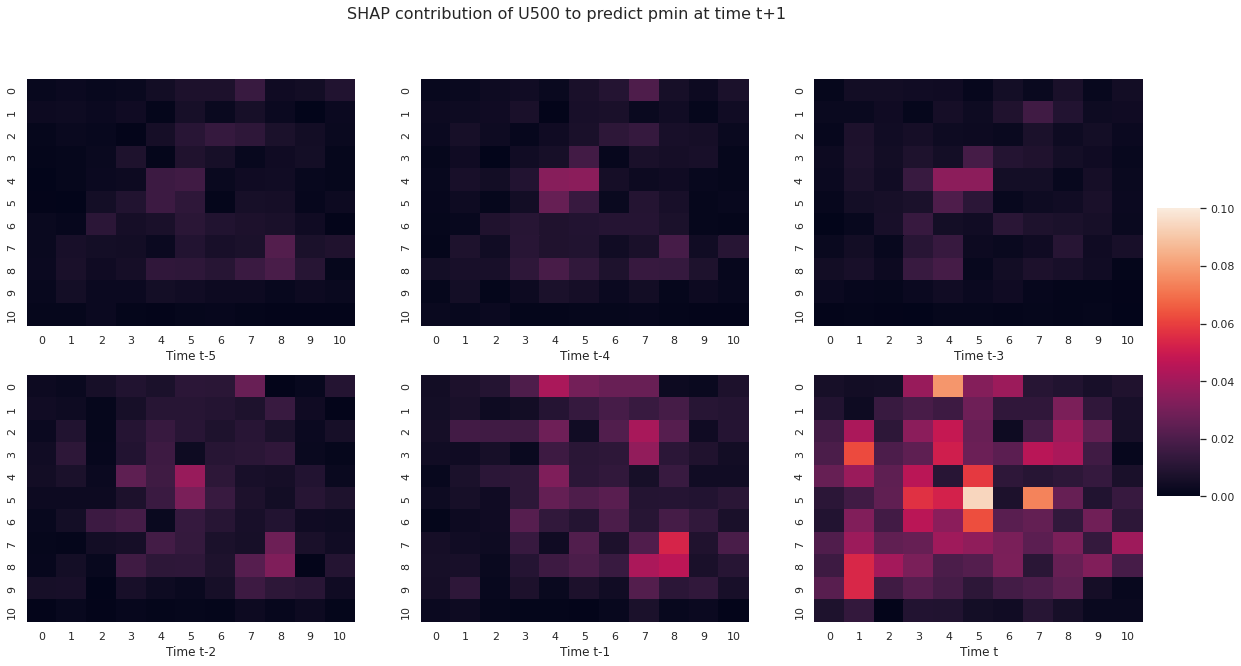

In [78]:
SHAP_ra(feature_id = 2, timestep = 0, shap_abs = shap_abs)

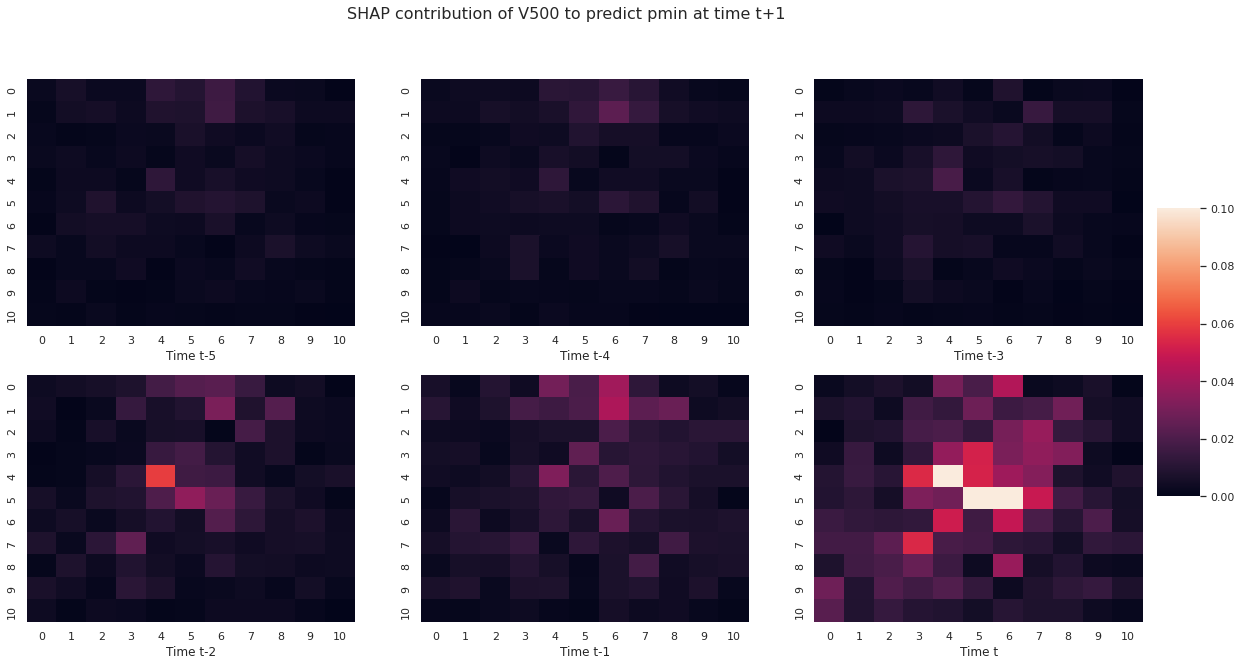

In [79]:
SHAP_ra(feature_id = 3, timestep = 0, shap_abs = shap_abs)

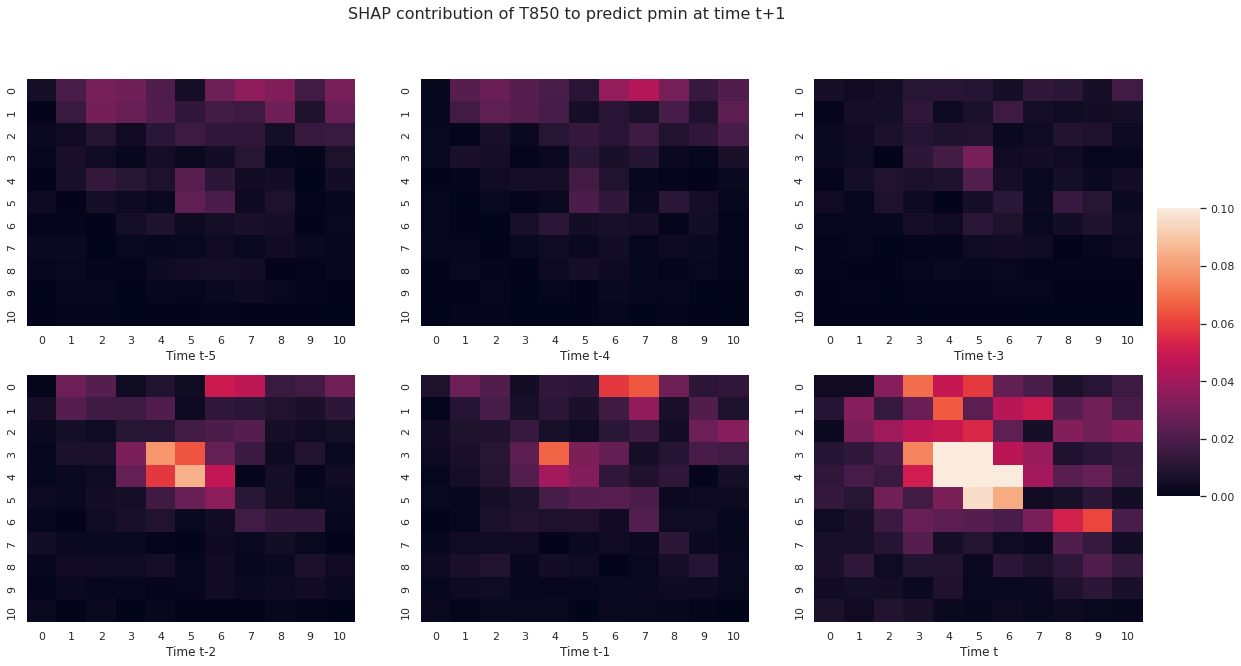

In [80]:
SHAP_ra(feature_id = 4, timestep = 0, shap_abs = shap_abs)

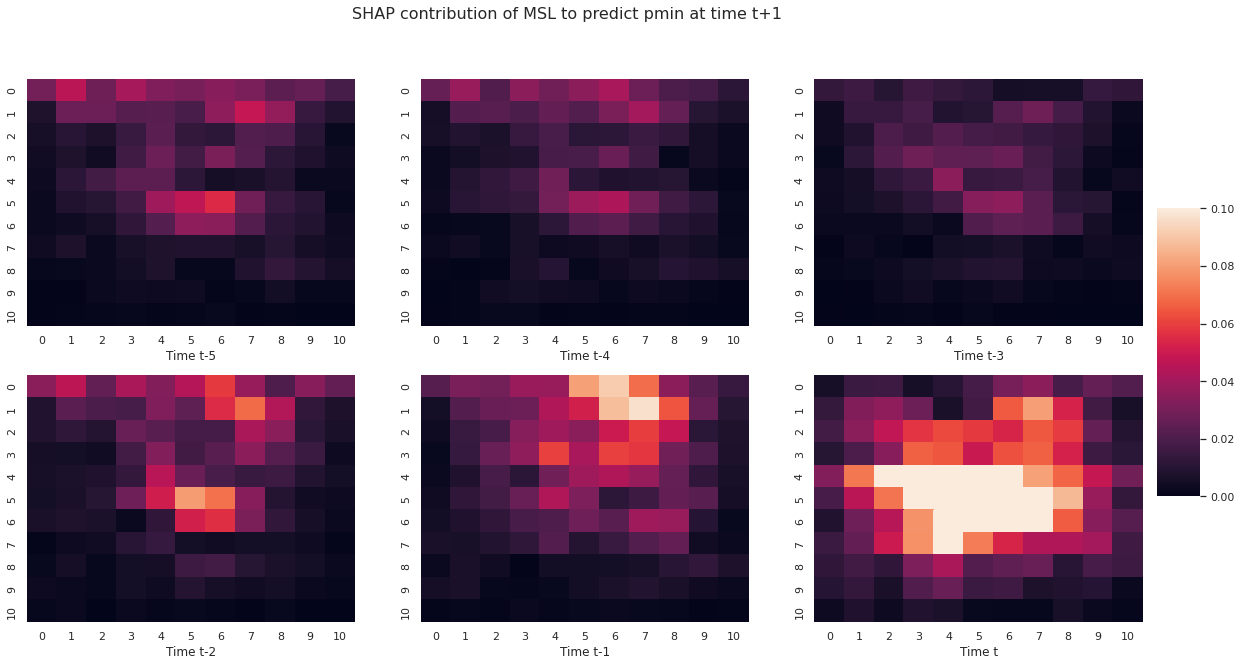

In [81]:
SHAP_ra(feature_id = 5, timestep = 0, shap_abs = shap_abs)

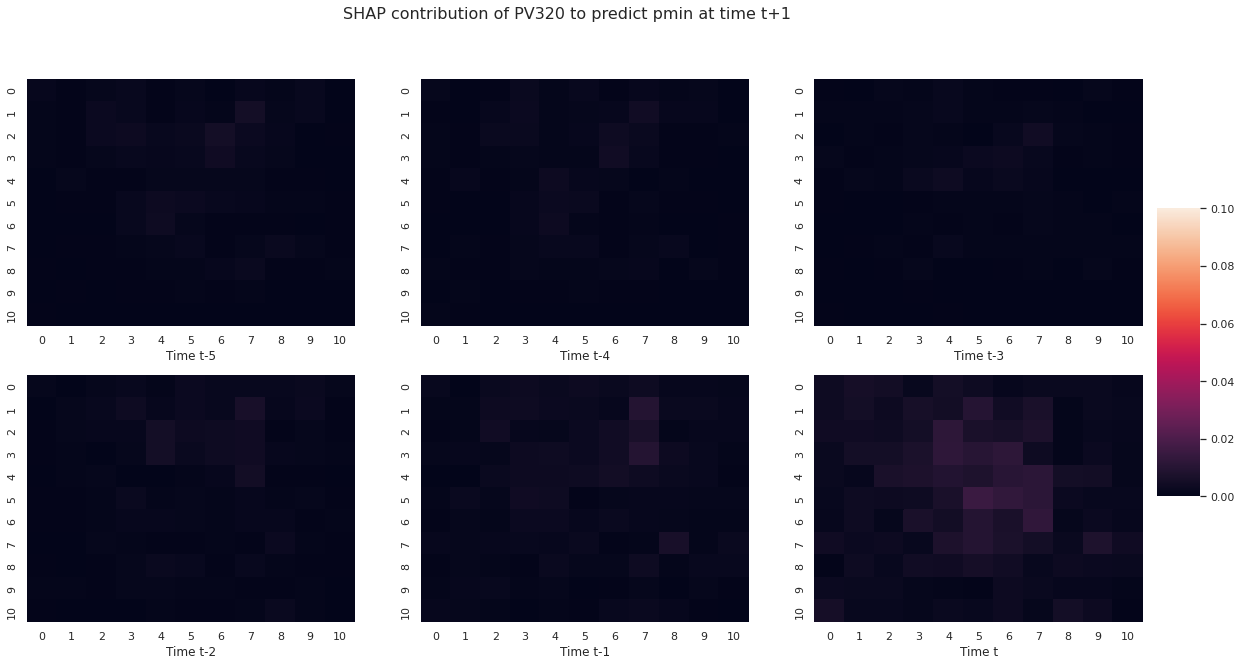

In [82]:
SHAP_ra(feature_id = 6, timestep = 0, shap_abs = shap_abs)